In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils

import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
lr = 0.001
BATCH_SIZE = 512
epochs = 10
num_classes = 10
latent_size = 128 # Size of the latent vector

In [ ]:
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

train_data = Datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = Datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.49MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.06MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.82MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Encoder

**In a VAE, the encoder takes an input and produces two outputs for each latent variable: a mean, $\mu$, and a standard deviation, $\sigma$.** These parameters define a Gaussian distribution for each dimension in the latent space.

To sample from this distribution while still allowing gradient descent, VAE use the **reparameterization trick.**

Normally, when you sample from a distribution, $N(\mu, \sigma^2)$, the sampling operation is non-differentiable, which means you can’t directly update the network parameters that produced $\mu$ and $\sigma$. This is because sampling directly from a standard distribution gives a random number, which we cannot use to update parameters.

By reparametrizing the sampling process, the gradients can be backpropagated, making the entire model differentiable. Instead of sampling $z$ directly, we first sample $\epsilon$ from a standard normal distribution $N(0,1)$. Because the operation $z = \mu + \sigma \cdot \epsilon$ is differentiable, gradients can flow back through $\mu$ and $\sigma$ during backpropagation.

This gives us the same functionality as sampling from $N(\mu, \sigma^2)$, because multiplying $N(0, 1)$ by the standard deviation and offsetting by the mean, does the same thing as the original standard distribution.

This is differentiable as:

$$
\frac{\partial \mu}{\partial z} = 1
$$

$$
\frac{\partial \sigma}{\partial z} = \epsilon
$$

This trick expresses a random sample $z$ as:

$$
z = \mu + \sigma \times \epsilon
$$

Where:

- $\mu$ is the mean of the distribution
- $\sigma$ is the standard deviation of the distribution
- $\epsilon$ is drawn from the distribution.

Note that the **probability distribution function is:**

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$

### Decoder

The decoder takes the sampled latent vector, $z$, and reconstructs the input similar to a regular AutoEncoder. It learns to generate data that is similar to the original input, effectively learning the data’s underlying distribution.

### KL Divergence Loss

KL Divergence Loss, otherwise known as the **Kullback–Leibler loss,** quantifies how one probability distribution diverges from a second, reference probability distribution. It is not symmetrical, meaning that the KL Loss between two probability distributions is not the same when the order of the two distributions is reversed.

The KL Divergence between two normal distributions where:

$$
p(x)=N(\mu_p,\sigma_p)
$$

$$
q(x)=N(\mu_q,\sigma_q)
$$

is:

$$
KL(p || q)=ln(\frac{\sigma_q}{\sigma_p})+\frac{\sigma^2_p+(\mu_p-\mu_q)^2}{2 \sigma^2_q}-\frac{1}{2}
$$

**Using the encoder, we produce a $\sigma$ and $\mu$ per dimension and sample from a gaussian distribution once per dimension with the given $\sigma$ and $\mu$. We then pass the sampled vector to the decoder which will try and reconstruct the original image.**

The KL loss tries to force the distribution from the encoder to be that of a unit gaussian where $\sigma = 1$ and $\mu = 0$ (also known as a Standard Normal Distribution).

To do this, we create a loss using the KL Divergence (a value that is always positive) between the distribution produced by the encoder and that of a unit gaussian.

So the above becomes:

$$
p(x)=N(\mu_p,\sigma_p)
$$

$$
q(x)=N(0, 1)
$$

$$
KL(p||q)= -\frac{1}{2} (1 + ln(\sigma_p) - \mu^2_p - \sigma_p^2)
$$

**We can use this loss function to minimize the loss by bringing our distribution closer to a unit Gaussian with mean 0 and standard deviation 1. This is also known as the prior.** We want to do this because when the latent distributions are close to $N(0, 1)$, we can easily sample new points from the latent space to generate new data. It also enables smooth interpolation between latent points, which is useful for generating meaningful variations. This also encourages the model to learn latent representations that are compatible across the entire dataset.

Once we calculate this KL Divergence Loss, we can add to the MSE loss between the original image and a reconstructed image. We add the KL Divergence multiplied by $\alpha$ to the MSE loss where $\alpha$ is the strength of the KL Divergence Loss.

$$
L = MSE + \alpha \cdot KL
$$

**We do this because we want to learn semantic latent representations between the latent space vectors for the mean and standard deviation, while still ensuring that the reconstructed data is coherent and similar to the original data.**

- Points that are close in latent space should have similar content after the decoder
- Sampling from the latent space should have meaningful content after the decoder

In [ ]:
def vae_loss(recon, x, mu, log_var):
  recon_loss = F.mse_loss(recon, x) # Reconstruction loss between reconstructed image and original

  # KL Divergence Loss
  # log_var = ln(\sigma_p)
  # log_var.exp() = \sigma_P^2 | This recovers the variance by exponenting the natural log by e
  kl_loss = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp()).mean() # We will use the mean instead of the sum to scale KL Divergence to be compatible with reconstruction loss

  # Tune the strength of KL divergance loss
  alpha = 0.1

  # The loss
  loss = recon_loss + alpha * kl_loss # We want high quality reconstructed images instead of regularization, so smaller value of alpha
  return loss

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.conv_1 = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=3,
                           stride=2,
                           padding=1)
    self.batch_norm_1 = nn.BatchNorm2d(out_channels)

    self.skip_conv = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=3,
                           stride=2,
                           padding=1)

    self.conv_2 = nn.Conv2d(in_channels=out_channels,
                           out_channels=out_channels,
                           kernel_size=3,
                           stride=1,
                           padding=1)
    self.batch_norm_2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x_skip = self.skip_conv(x) # (batch_size, in_channels, size, size) -> (batch_size, out_channels, size / 2, size / 2)

    x = F.elu(self.batch_norm_1(self.conv_1(x))) # (batch_size, in_channels, size, size) -> (batch_size, out_channels, size / 2, size / 2)

    # self.conv_2 keeps the H and W dimensions the same
    x = self.conv_2(x) + x_skip # Add the output of a skip conv layer

    return F.elu(self.batch_norm_2(x)) # (batch_size, out_channels, size / 2, size / 2)

class DecoderBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()

    self.batch_norm_1 = nn.BatchNorm2d(in_channels)
    self.conv_1 = nn.Conv2d(in_channels=in_channels,
                            out_channels=in_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

    self.skip_conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

    self.batch_norm_2 = nn.BatchNorm2d(in_channels)
    self.conv_2 = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

    self.upscale = nn.Upsample(scale_factor=2, mode="nearest") # Simple upsampling by a factor of 2 (Turn every pixel into a 2x2 square with the same values)

  def forward(self, x):
    x_skip = self.upscale(self.skip_conv(x)) # (batch_size, in_channels, size, size) -> (batch_size, out_channels, size * 2, size * 2)
    x = F.elu(self.batch_norm_1(x)) # (batch_size, in_channels, size, size)

    x = self.upscale(F.elu(self.batch_norm_2(self.conv_1(x)))) # (batch_size, in_channels, size * 2, size * 2)
    return self.conv_2(x) + x_skip # (batch_size, out_channels, size * 2, size * 2)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,
               in_channels: int,
               out_channels: int = 32,
               latent_size: int = 32):
    super().__init__()
    self.conv_in = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

    self.conv_block_1 = EncoderBlock(in_channels=out_channels, out_channels=out_channels)
    self.conv_block_2 = EncoderBlock(in_channels=out_channels, out_channels=(out_channels * 2))
    self.conv_block_3 = EncoderBlock(in_channels=(out_channels * 2), out_channels=(out_channels * 4))

    # Instead of flattening (and then having to unflatten) out our feature map and putting it through a linear layer, we can use a conv layer
    # Even though mean and log variance are learned conv layers, they behave as they should because of their output's use in the reparameterization trick and the loss calculation
    self.conv_mu = nn.Conv2d(in_channels=(out_channels * 4),
                             out_channels=latent_size,
                             kernel_size=4,
                             stride=1)
    self.conv_log_var = nn.Conv2d(in_channels=(out_channels * 4),
                                  out_channels=latent_size,
                                  kernel_size=4,
                                  stride=1)

  def sample(self, mu, log_var):
    std = torch.exp(0.5 * log_var) # Get the standard deviation
    eps = torch.randn_like(std) # Random numbers in shape of std that are sampled from standard distribution with mean 0 and variance 1
    return mu + eps * std # reparameterization trick

  def forward(self, x):
    x = F.elu(self.conv_in(x)) # (batch_size, 1, 32, 32) -> (batch_size, 16, 32, 32)

    x = self.conv_block_1(x) # (batch_size, 16, 32, 32) -> (batch_size, 16, 16, 16)
    x = self.conv_block_2(x) # (batch_size, 16, 16, 16) -> (batch_size, 32, 8, 8)
    x = self.conv_block_3(x) # (batch_size, 32, 8, 8) -> (batch_size, 64, 4, 4)

    mu = self.conv_mu(x) # (batch_size, 64, 4, 4) -> (batch_size, 128, 1, 1)
    log_var = self.conv_log_var(x) # (batch_size, 64, 4, 4) -> (batch_size, 128, 1, 1)

    x = self.sample(mu, log_var) # Get the latent representation using the reparameterization trick

    return x, mu, log_var

class Decoder(nn.Module):
  def __init__(self,
                in_channels: int,
                out_channels: int = 32,
                latent_size: int = 32):
    super().__init__()

    self.conv_in = nn.ConvTranspose2d(in_channels=latent_size,
                                      out_channels=(4 * out_channels),
                                      kernel_size=4,
                                      stride=1)

    self.conv_block_1 = DecoderBlock(in_channels=(4 * out_channels), out_channels=(2 * out_channels))
    self.conv_block_2 = DecoderBlock(in_channels=(2 * out_channels), out_channels=out_channels)
    self.conv_block_3 = DecoderBlock(in_channels=out_channels, out_channels=out_channels)

    self.conv_out = nn.Conv2d(in_channels=out_channels,
                              out_channels=in_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)

  def forward(self, x):
    x = self.conv_in(x) # (batch_size, 128, 1, 1) -> (batch_size, 64, 4, 4)

    x = self.conv_block_1(x) # (batch_size, 64, 4, 4) -> (batch_size, 32, 8, 8)
    x = self.conv_block_2(x) # (batch_size, 32, 8, 8) -> (batch_size, 64, 16, 16)
    x = self.conv_block_3(x) # (batch_size, 64, 16, 16) -> (batch_size, 64, 32, 32)

    return torch.tanh(self.conv_out(F.elu(x))) # (batch_size, 1, 32, 32)

In [ ]:
class VAE(nn.Module):
  def __init__(self,
               in_channels: int,
               out_channels: int = 16,
               latent_size: int = 32):
    super().__init__()

    self.encoder = Encoder(in_channels=in_channels, out_channels=out_channels, latent_size=latent_size)
    self.decoder = Decoder(in_channels=in_channels, out_channels=out_channels, latent_size=latent_size)

  def forward(self, x):
    encoding, mu, log_var = self.encoder(x)

    # When the model is in train mode, sample using the output of the encoder
    # When the model is in eval mode, sample using the mean from the latent representation
    if self.training:
      x = self.decoder(encoding)
    else:
      x = self.decoder(mu)

    return x, mu, log_var

In [ ]:
test_images = next(iter(test_dataloader))[0]
test_images.shape #(batch_size, 1, H, W)

torch.Size([512, 1, 32, 32])

(-0.5, 273.5, 35.5, -0.5)

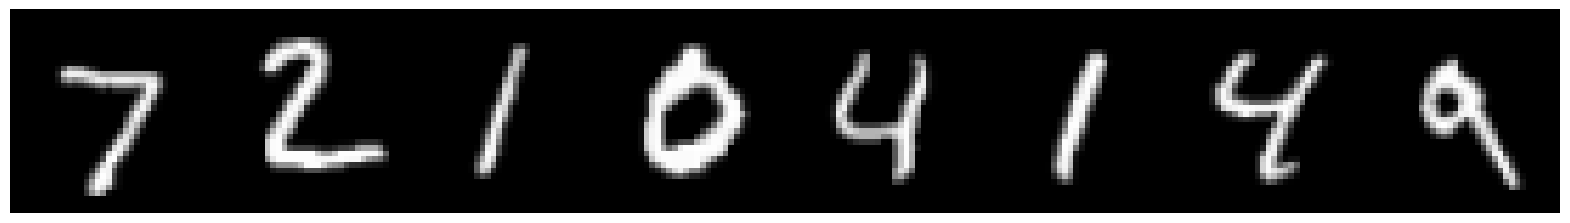

In [ ]:
plt.figure(figsize=(20, 10))

out = vutils.make_grid(test_images[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

In [ ]:
print(f"Min Pixel Value: {test_images.min()} | Max Pixel Value: {test_images.max()}")

Min Pixel Value: -1.0 | Max Pixel Value: 1.0


In [ ]:
model = VAE(in_channels=1, out_channels=16, latent_size=latent_size).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.5, 0.999))

In [ ]:
recon_data, mu, log_var = model(test_images.to(device))
print(recon_data.shape, mu.shape, log_var.shape)

torch.Size([512, 1, 32, 32]) torch.Size([512, 128, 1, 1]) torch.Size([512, 128, 1, 1])


In [ ]:
model_path = "vae_model.pt"
pbar = trange(0, epochs, leave=False, desc="Epoch")

model.train()

for epoch in pbar:
  train_loss = 0

  for i, (image, label) in enumerate(tqdm(train_dataloader, leave=False, desc="Training")):
    image = image.to(device)

    # Reconstructed image data, mean of latent vector, log variance of latent vector
    recon_data, mu, log_var = model(image)

    # Calculate the KL Divergence Loss
    loss = vae_loss(recon_data, image, mu, log_var)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | Loss: {train_loss / len(train_dataloader)}")
  pbar.set_postfix_str(f"Loss: {train_loss / len(train_dataloader)}")

  torch.save(model.state_dict(), model_path)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.15491781390066875


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2 | Loss: 0.08126238083182755


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3 | Loss: 0.06931536328994621


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4 | Loss: 0.06417561044632378


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5 | Loss: 0.060988022582763333


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6 | Loss: 0.05955079725106894


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7 | Loss: 0.05760409591435376


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8 | Loss: 0.05671163954598419


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9 | Loss: 0.05600074141965074


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 | Loss: 0.05489314871571832


In [ ]:
# Predictions

model.eval()
with torch.inference_mode():
  # Reconstructed image data, mean of latent vector, log variance of latent vector
  recon_data, mu, log_var = model(test_images.to(device))

(-0.5, 273.5, 35.5, -0.5)

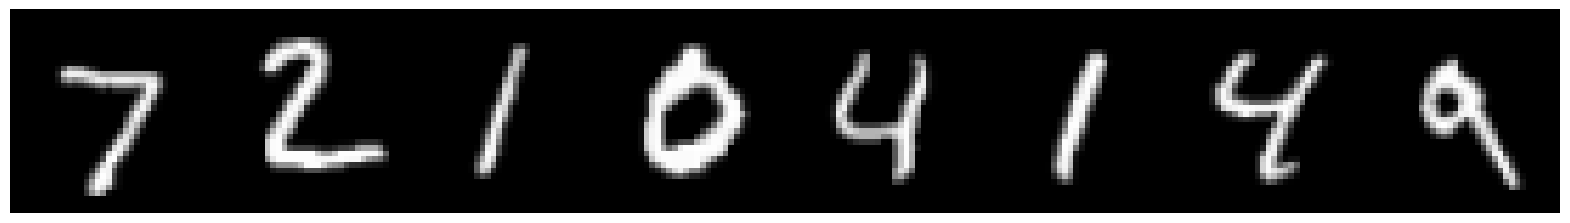

In [ ]:
# Ground Truth

plt.figure(figsize=(20, 10))
out = vutils.make_grid(test_images[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

(-0.5, 273.5, 35.5, -0.5)

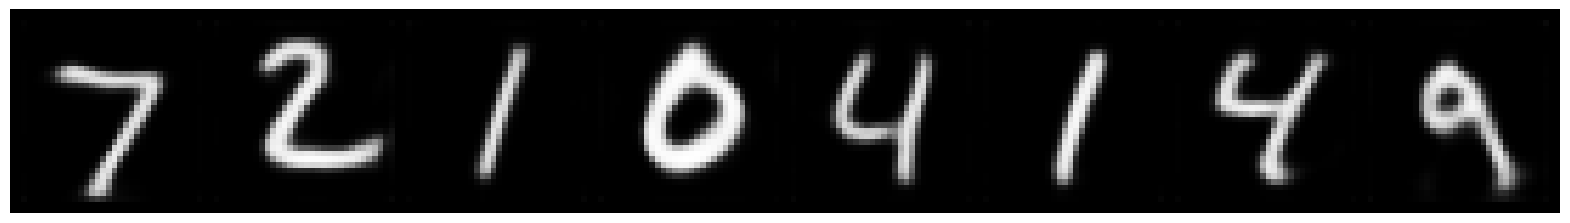

In [ ]:
# Reconstruction

plt.figure(figsize=(20, 10))
out = vutils.make_grid(recon_data.detach().cpu()[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

(-0.5, 273.5, 35.5, -0.5)

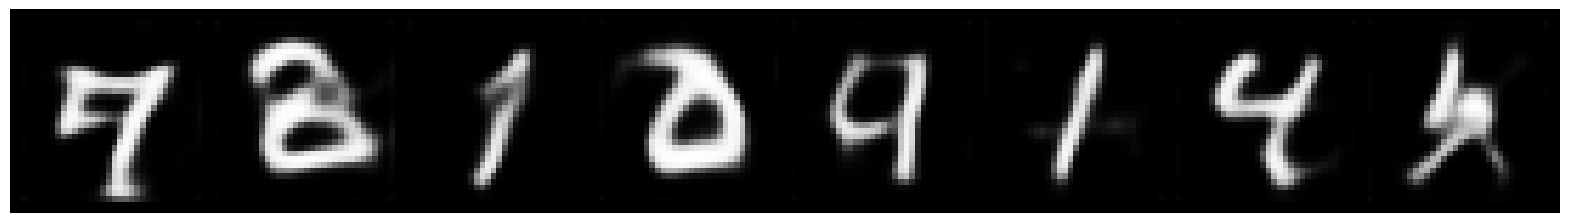

In [ ]:
# Random Permutations

rand_samp = model.decoder(mu + 1 * torch.randn_like(mu))
plt.figure(figsize=(20, 10))
out = vutils.make_grid(rand_samp.detach().cpu()[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

(-0.5, 273.5, 35.5, -0.5)

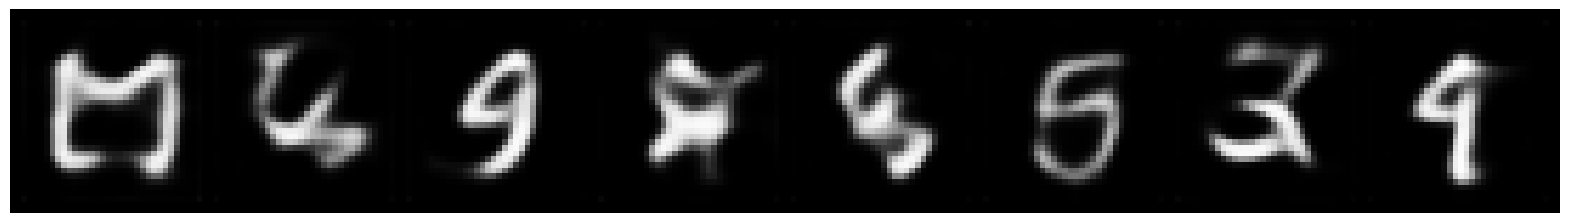

In [ ]:
# Random Permutations

rand_samp = model.decoder(torch.randn_like(mu))
plt.figure(figsize=(20, 10))
out = vutils.make_grid(rand_samp.detach().cpu()[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

In [ ]:
model.eval()

latent_vectors = []
all_labels = []

with torch.inference_mode():
  for images, labels in test_dataloader:
    images = images.to(device)
    encoding, mu, log_var = model.encoder(images)

    # Shape: (batch_size, latent_size, 1, 1) -> (batch_size, latent_size)
    latent_vectors.append(mu.squeeze(dim=-1).squeeze(dim=-1).cpu())
    all_labels.append(labels)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()
all_labels = torch.cat(all_labels).numpy()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent_vectors)

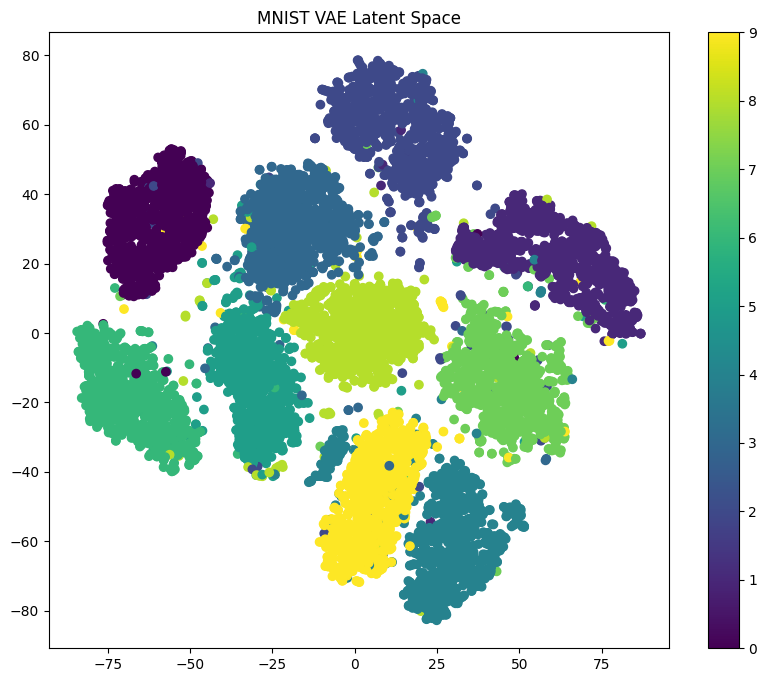

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=all_labels)
plt.colorbar(scatter)
plt.title("MNIST VAE Latent Space")
plt.show()

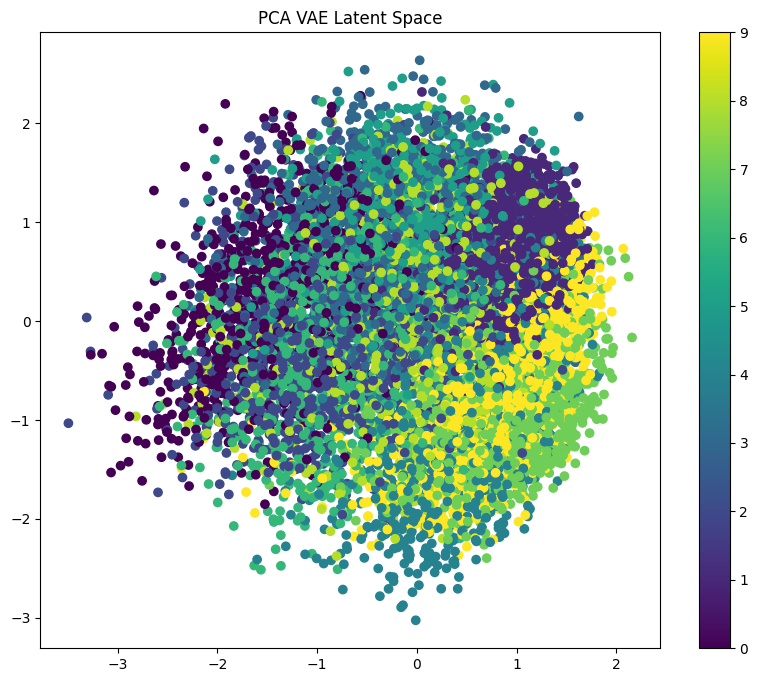

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver="auto", random_state=0)
latent_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=all_labels)
plt.colorbar(scatter)
plt.title("PCA VAE Latent Space")
plt.show()

In [ ]:
latent_2d[0]

array([ 1.7034556, -1.1675258], dtype=float32)

(-0.5, 273.5, 35.5, -0.5)

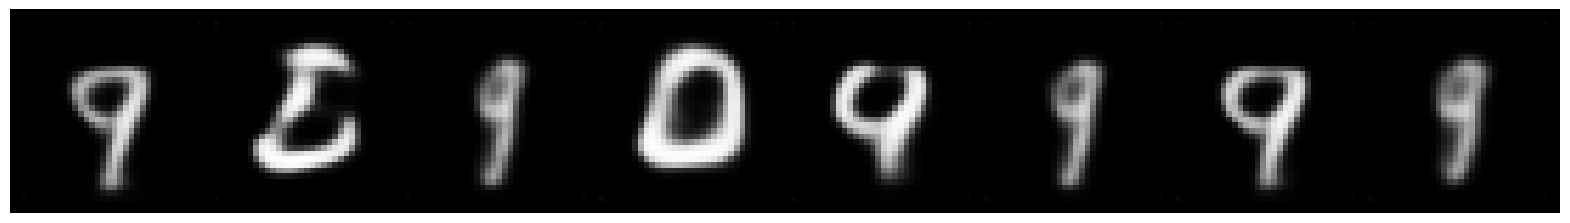

In [ ]:
latent_vect = pca.inverse_transform(latent_2d)
recon_vect = model.decoder(torch.tensor(latent_vect).unsqueeze(dim=-1).unsqueeze(dim=-1).to(device))

plt.figure(figsize=(20, 10))
out = vutils.make_grid(recon_vect.detach().cpu()[:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

In [ ]:
latent_vect = pca.inverse_transform([0, 0])
torch.tensor(latent_vect).unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0).shape

torch.Size([1, 128, 1, 1])

In [ ]:
def explore_latent_space(x, y):
  latent_vect = pca.inverse_transform(np.array([x, y]))
  recon_vect = model.decoder(torch.tensor(latent_vect, dtype=torch.float).unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0).to(device))

  return recon_vect.detach().cpu().numpy()

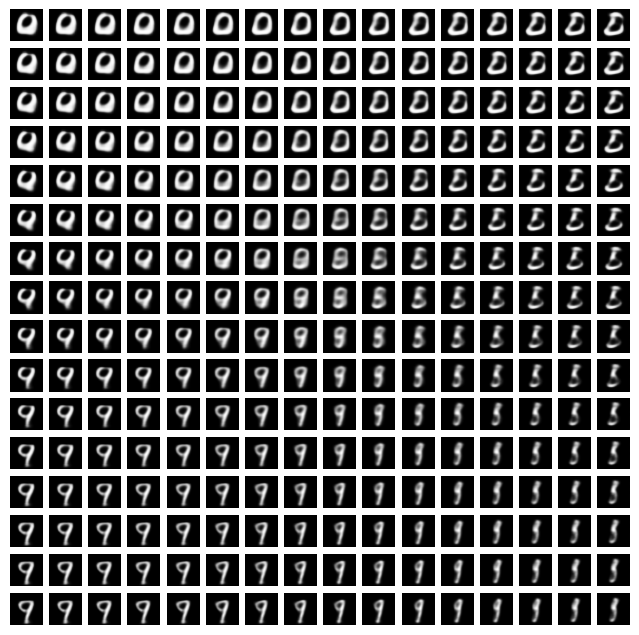

In [ ]:
rows, cols = 16, 16

x_values = np.linspace(-2, 2, rows)
y_values = np.linspace(-2, 2, cols)

fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

for i, x in enumerate(x_values):
  for j, y in enumerate(y_values):
    img = explore_latent_space(x, y).squeeze()

    axes[i, j].imshow(img, cmap='gray')
    axes[i, j].axis(False)

plt.show()